<div style="text-align: center;">
    King Fahd University of Petroleum & Minerals <br>
    College of Computing and Mathematics <br>
    Information and Computer Science Department
</div>

<div style="text-align: center;">
    241-ICS-560-1 (Foundations of Quantum Computing)
</div>

<div style="text-align: center;">
    Quantum Key Distribution: A Simple BB84 Protocol Simulation
</div>

<div style="text-align: center;">
    Omar Saeed Alshammari, 200819560 <br>
    Bander Saeed Alshammari, 201239040
</div>

<div style="text-align: center;">
    Dr Alawi A. Al-Saggaf
</div>

<div style="text-align: center;">
    13 Dec 2024
</div>


# Table of Contents
1. [Project Overview](#Project-Overview)
2. [Background and Literature Review](#Background-and-Literature-Review)
3. [Methodology](#Methodology)
4. [Implementation](#Implementation)
5. [Results and Analysis](#Results-and-Analysis)
6. [Challenges Encountered](#Challenges-Encountered)
7. [Conclusion](#Conclusion)
7. [References](#References)

## Project Overview


## Background and Literature Review


## Methodology

## Implementation

In [ ]:
# Introudction
Implement a basic version of the BB84 protocol, 
which introduces you to quantum cryptography and the concept of quantum-secure communication.

Alice original bits
[0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1]
Bob Measurments is:
[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0]
48-bit derived key: 110110110101101001000001010111011100000111101100
[2, 3, 5, 8, 10, 11, 15, 18, 19, 22, 23, 26, 27]
48-bit derived key: 110110110101101001000001010111011100000111101100
[1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0]
[1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0]
Alice's sifted key count is:13
Bob's sifted key count is:13
Key exchange was successful.


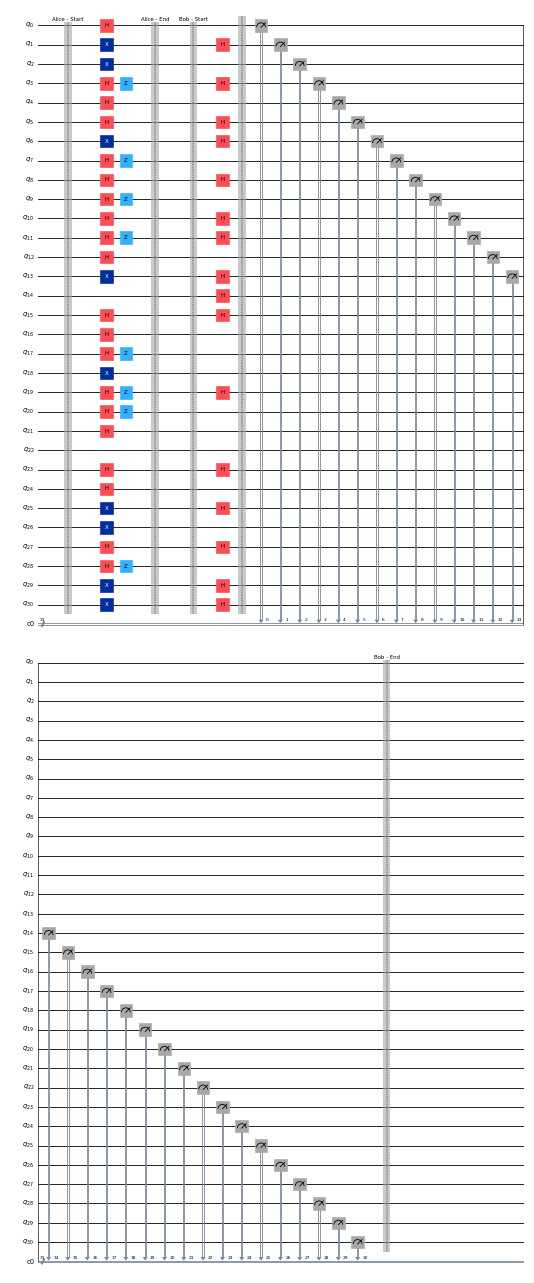

In [ ]:
from qiskit import QuantumCircuit
from main import simulate_bb84_without_eve
num_qubits = 31
qc = QuantumCircuit(num_qubits)
simulate_bb84_without_eve(qc, num_qubits)

qc.draw(output='mpl', scale= 0.3)


In [ ]:
from main import simulate_bb84_with_eve
qc_with_eve = QuantumCircuit(num_qubits)
simulate_bb84_with_eve(qc_with_eve, num_qubits)
qc_with_eve.draw(output='mpl', scale= 0.3)